### The CIFAR-100 dataset consists of 60000 32x32 colour images in 100 classes, with 6000 images per class. There are 50000 training images and 10000 test images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# from datetime import datetime
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

## Importing the Cifar 100 Dataset

In [ ]:
cifar100 = tf.keras.datasets.cifar100
(X_train, Y_train), (X_test,Y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 8s 0us/step


##  Plotting some images from the dataset

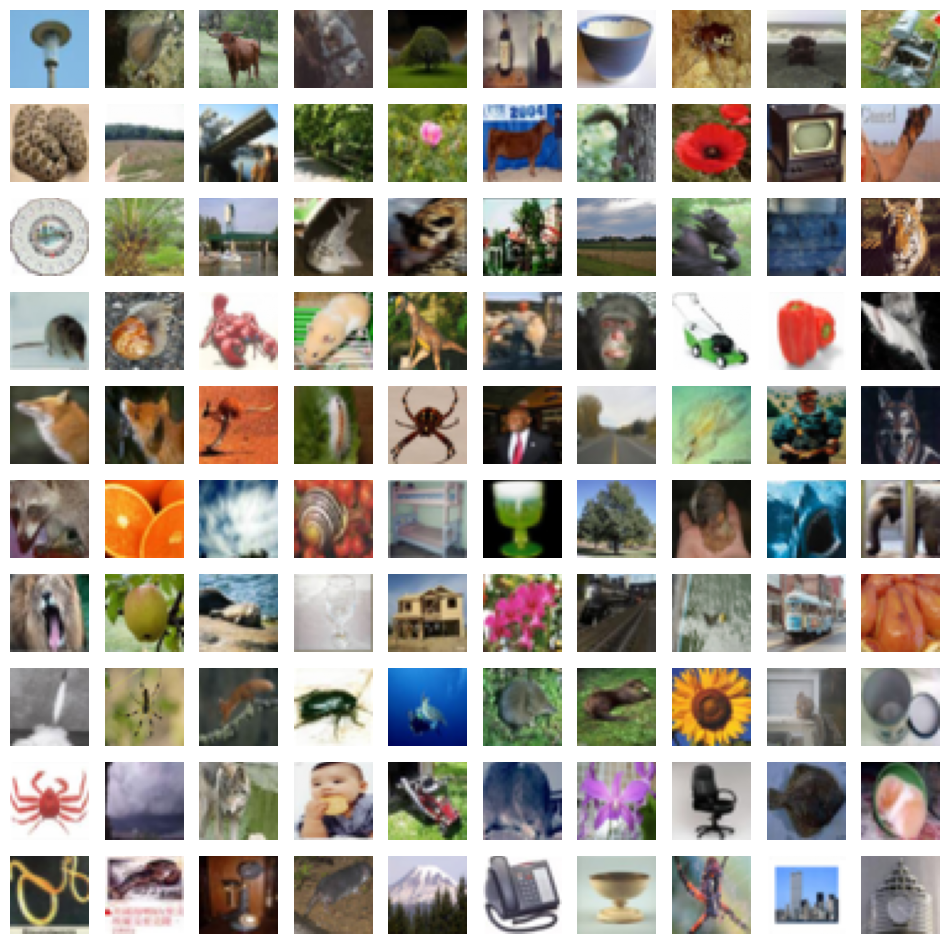

In [ ]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1 +i)
  plt.axis('off')
  plt.imshow(X_train[i],cmap='gray')

## Splitting the train data again - we use the val set as test set and previous test set for final predictions

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train, Y_train, test_size = 0.2)

##  Onehot encoding of the outputs

In [ ]:
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)
y_test = to_categorical(Y_test, num_classes = 100)

In [ ]:
X_train = X_train * 1.0/255
X_val = X_val * 1.0/255
X_test = X_test * 1.0/255

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


##  Image Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(X_train)

##  Reduce Learning Rate if accuracy is not improving for 3 epochs

##  Importing the Resnet Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

##  Converting the output layer as per our dataset

In [ ]:
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

checkpoint = ModelCheckpoint("/content/drive/MyDrive/cifar100.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1
                             )


earlystop = EarlyStopping(monitor = 'val_loss', #value being monitored for improvement
                          min_delta = 0.001,  #Abs value and is the main change required before we stop
                          patience = 5, #no of epocs we wait before stopping
                          verbose = 1,
                          restore_best_weights = True) #keep the best weigts once stopped

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.6,
                              patience = 3,
                              verbose = 1,
                              min_delta = 1e-6)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

Keras provides an upsampling layer – called UpSampling2D – which allows to perform upsampling operation within neural networks
* ### 32 * 7 = 224


### Stochastic gradient descent optimizer with momentum.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

Compile the model

In [ ]:
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

We now Train the model on images. we are also checking to see if validation accuracy doesnt improve we will reduce learning rate though the callback

In [ ]:

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size = 32),
    validation_data = (X_val, y_val),
    epochs = 25,
    verbose = 1,
    callbacks = [callbacks]
)
model.save("/content/drive/MyDrive/cifar100.h5")

Epoch 1/25
1250/1250 [==============================] - ETA: 0s - loss: 3.1979 - accuracy: 0.2524
Epoch 1: val_loss improved from inf to 2.12223, saving model to /content/drive/MyDrive/catvsdog/multi_image_cat_dog.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 365s 281ms/step - loss: 3.1979 - accuracy: 0.2524 - val_loss: 2.1222 - val_accuracy: 0.4494 - lr: 0.0010
Epoch 2/25
1250/1250 [==============================] - ETA: 0s - loss: 2.0645 - accuracy: 0.4607
Epoch 2: val_loss improved from 2.12223 to 1.65320, saving model to /content/drive/MyDrive/catvsdog/multi_image_cat_dog.h5
1250/1250 [==============================] - 354s 283ms/step - loss: 2.0645 - accuracy: 0.4607 - val_loss: 1.6532 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 3/25
1250/1250 [==============================] - ETA: 0s - loss: 1.7296 - accuracy: 0.5328
Epoch 3: val_loss improved from 1.65320 to 1.42113, saving model to /content/drive/MyDrive/catvsdog/multi_image_cat_dog.h5
1250/1250 [==============================] - 339s 271ms/step - loss: 1.7296 - accuracy: 0.5328 - val_loss: 1.4211 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 4/25
1250/1250 [==============================] - ETA: 0s - loss: 1.5333 - accuracy: 0.5769
Epoch 4: v

In [ ]:
model.save("cifar100.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("/content/drive/MyDrive/cifar100.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('my_model.keras')

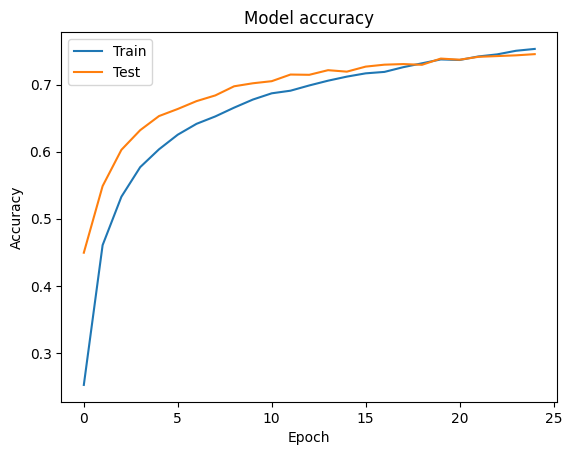

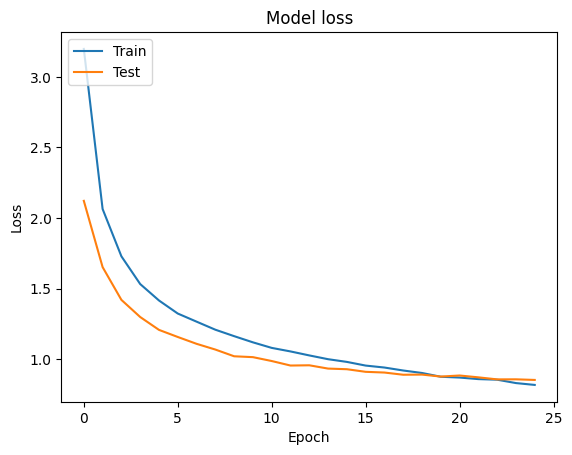

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Define the class names for CIFAR-100
cifar100_class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
    'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man',
    'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
    'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Print class label names along with their corresponding class indices
for index, label_name in enumerate(cifar100_class_names):
   classes=  print(f"{index}: {label_name}")
print(classes)

0: apple
1: aquarium_fish
2: baby
3: bear
4: beaver
5: bed
6: bee
7: beetle
8: bicycle
9: bottle
10: bowl
11: boy
12: bridge
13: bus
14: butterfly
15: camel
16: can
17: castle
18: caterpillar
19: cattle
20: chair
21: chimpanzee
22: clock
23: cloud
24: cockroach
25: couch
26: crab
27: crocodile
28: cup
29: dinosaur
30: dolphin
31: elephant
32: flatfish
33: forest
34: fox
35: girl
36: hamster
37: house
38: kangaroo
39: keyboard
40: lamp
41: lawn_mower
42: leopard
43: lion
44: lizard
45: lobster
46: man
47: maple_tree
48: motorcycle
49: mountain
50: mouse
51: mushroom
52: oak_tree
53: orange
54: orchid
55: otter
56: palm_tree
57: pear
58: pickup_truck
59: pine_tree
60: plain
61: plate
62: poppy
63: porcupine
64: possum
65: rabbit
66: raccoon
67: ray
68: road
69: rocket
70: rose
71: sea
72: seal
73: shark
74: shrew
75: skunk
76: skyscraper
77: snail
78: snake
79: spider
80: squirrel
81: streetcar
82: sunflower
83: sweet_pepper
84: table
85: tank
86: telephone
87: television
88: tiger
89: t

1/1 [==============================] - 1s 880ms/step


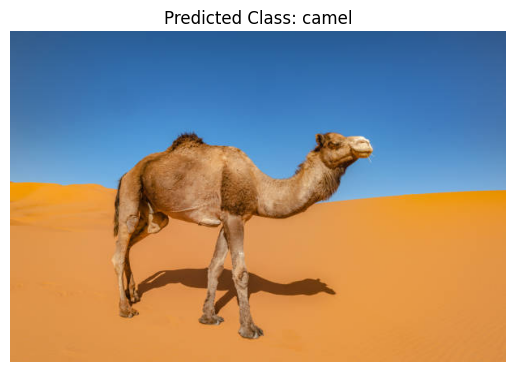

The predicted class =  camel


In [ ]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt

# Load your pre-trained model
model = load_model('/content/drive/MyDrive/cifar100.h5')

# Load and preprocess the test image
test_img = cv2.imread('/content/istockphoto-1174299659-612x612.jpg')
img = cv2.resize(test_img, (32 , 32), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 32, 32, 3))
img = img / 255.0

# Make predictions
pred = model.predict(img)
class_num = np.argmax(pred)

# Define your class names (specific to your dataset)
cifar100_class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
    'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man',
    'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
    'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
] # Replace with your actual class names

# Get the predicted class name
predicted_class_name = cifar100_class_names[class_num]

# Display the image
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')  # Hide axis
plt.show()

# Print the predicted class name
print("The predicted class = ", predicted_class_name)


## Predictions,Accuracy and Confusion Matrix

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape)

313/313 [==============================] - 27s 87ms/step
(10000,) (10000,)


In [ ]:
print(y_pred)
print(y_true)

[68 33 30 ... 51 42 70]
[49 33 72 ... 51 42 70]


In [ ]:
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

Testing Accuracy:  0.7406


In [ ]:
conf_matrix = confusion_matrix(y_true,y_pred)
print(conf_matrix)
classifi_report=classification_report(y_true,y_pred)
print(classifi_report)

[[84  0  0 ...  0  0  0]
 [ 0 76  1 ...  0  0  0]
 [ 0  1 64 ...  0  5  0]
 ...
 [ 0  0  0 ... 76  0  0]
 [ 0  0  4 ...  0 63  0]
 [ 0  0  0 ...  0  0 79]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       100
           1       0.92      0.76      0.83       100
           2       0.61      0.64      0.62       100
           3       0.86      0.44      0.58       100
           4       0.55      0.56      0.55       100
           5       0.72      0.82      0.77       100
           6       0.83      0.75      0.79       100
           7       0.67      0.85      0.75       100
           8       0.83      0.89      0.86       100
           9       0.91      0.86      0.89       100
          10       0.72      0.55      0.63       100
          11       0.52      0.50      0.51       100
          12       0.77      0.82      0.80       100
          13       0.79      0.75      0.77       100
          14       0.56      0.83

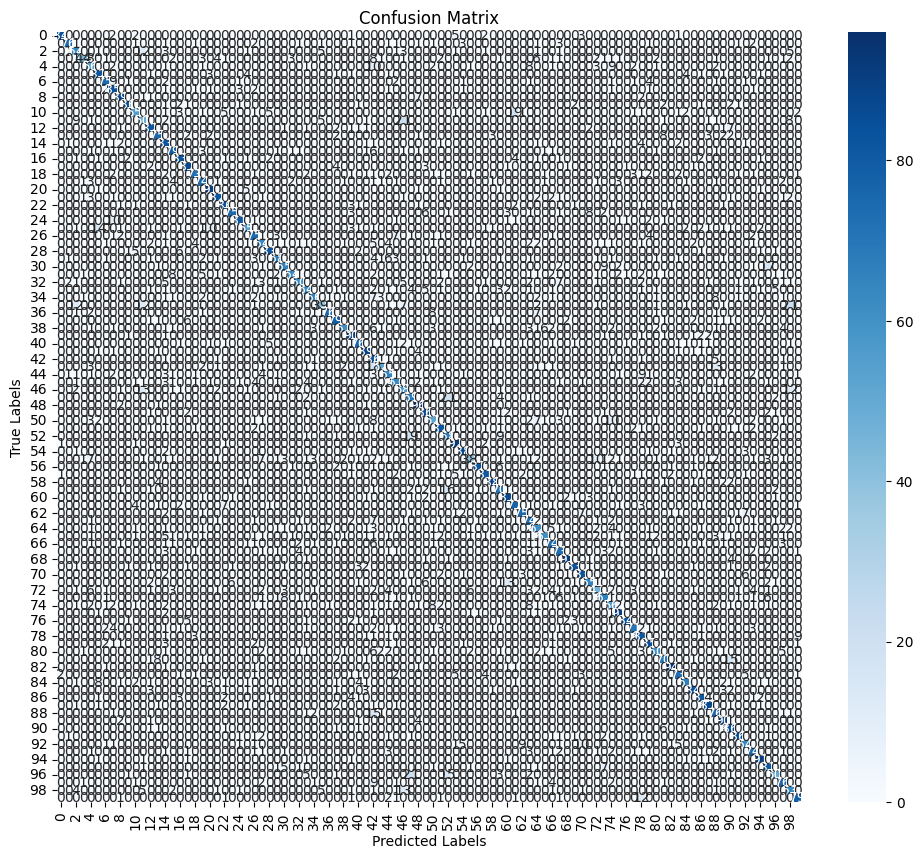

In [ ]:
# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues'))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


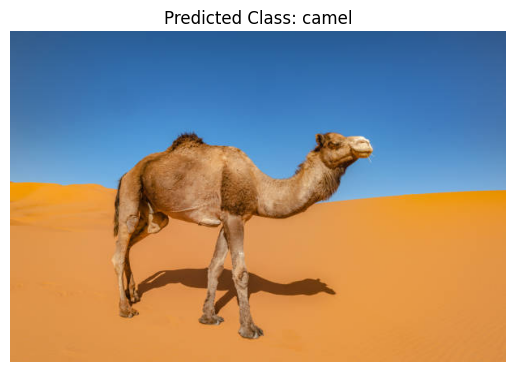

The predicted class =  camel


In [ ]:
import numpy as np
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt

# Load your pre-trained model
model = load_model('/content/drive/MyDrive/cifar100.h5')

# Load and preprocess the test image
test_img = cv2.imread('/content/istockphoto-1174299659-612x612.jpg')
img = cv2.resize(test_img, (32, 32), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 32, 32, 3))
img = img / 255.0

# Make predictions
pred = model.predict(img)
class_num = np.argmax(pred)

# Define your class names (specific to your dataset)
cifar100_class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
    'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man',
    'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
    'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
] # Replace with your actual class names

# Get the predicted class name
predicted_class_name = cifar100_class_names[class_num]

# Display the image
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')  # Hide axis
plt.show()

# Print the predicted class name
print("The predicted class = ", predicted_class_name)
